# Roofline experiments

We'll investigate the cross-over point from memory bandwidth bound to compute
bound for vector and matrix operations on Cloud TPU.

c.f. https://cloud.google.com/tpu/docs/system-architecture-tpu-vm, a TPU has both
a vector unit (VPU) and one or more matrix units (MXU). We'll benchmark both and
see if we can fit a roofline model over them.

In [1]:
import torch
import torch_xla
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

from dataclasses import dataclass


@dataclass
class Spec:
  mxu_flops: int
  """BF16 flops per second per chip."""

  hbm_bandwidth: int
  """HBM bandwidth in bytes per second."""
  
  def arithmetic_intensity(self):
    """Arithmetic intensity in FLOPS/byte."""
    return self.mxu_flops / self.hbm_bandwidth
  

T = 1e12  # Tera

TPU_SPEC = {
  "v4": Spec(
    mxu_flops=275 * T,
    hbm_bandwidth=int(1.2 * T),
  ),
  "v5litepod": Spec(
    mxu_flops=197 * T,
    hbm_bandwidth=int(0.819 * T),
  ),
  "v6e": Spec(
    mxu_flops=918 * T,
    hbm_bandwidth=int(1.64 * T),
  ),
}

tpu_spec = TPU_SPEC[torch_xla.tpu.get_tpu_type()]

## Vector roofline

In [2]:
from functools import reduce
import time
import numpy as np
import torch_xla.core.xla_model as xm


@dataclass
class BenchmarkResult:
  flops: float
  """Number of floating point operations per second."""
  
  arithmetic_intensity: float
  """Number of floating point operations done per byte transferred (FLOPS/byte)."""
  
  @property
  def tflops(self):
    """Number of tera floating point operations per second."""
    return self.flops / 1e12

  def __str__(self):
    return f"{self.tflops:.4f} TFLOP/s, {self.arithmetic_intensity:.4f} FLOPS/byte"


def run_ops(operands, num_operations):
  match num_operations:
    case 1:
      # Benchmark N-1 sums
      return sum(operands)
    case 2:
      # Benchmark N-1 sums and N-1 multiplications and one final sum
      return run_ops(operands, num_operations-1) + reduce(lambda x, y: x * y, operands)
    case 3:
      # Benchmark N-1 sums and N-1 multiplications and N-1 subtractions and two final sums
      return run_ops(operands, num_operations-1) + reduce(lambda x, y: x - y, operands)
    case 4:
      # Benchmark N-1 sums and N-1 multiplications and N-1 subtractions and N-1 divisions and three final sums
      return run_ops(operands, num_operations-1) + reduce(lambda x, y: x / y, operands)
    case 5:
      # Benchmark N-1 sums and N-1 multiplications and N-1 subtractions and N-1 divisions and N-1 clamp-min and four final sums
      return run_ops(operands, num_operations-1) + reduce(lambda x, y: torch.clamp(x, min=y), operands)
    case 6:
      # Benchmark N-1 sums and N-1 multiplications and N-1 subtractions and N-1 divisions and N-1 clamp-min and N-1 clamp-max and five final sums
      return run_ops(operands, num_operations-1) + reduce(lambda x, y: torch.clamp(x, max=y), operands)
    case _:
      return run_ops(operands, num_operations-1) + run_ops([torch.clamp(o, min=-float(num_operations)) for o in operands], num_operations-6)


def measure_vector_flops(num_operands: int, num_operations: int):
  NUM_ITERS = 100
  SIZE = 16384
  operands = []
  for _ in range(num_operands):
    operands.append(torch.randn(SIZE, SIZE, dtype=torch.bfloat16, requires_grad=False, device=xm.xla_device()))
    torch_xla.sync()
  # Measure in a loop
  times = []

  def count_flops(num_operands, num_operations):
    if num_operations <= 6:
      return SIZE * SIZE * (num_operands - 1) * num_operations + ((SIZE * SIZE) * (num_operations - 1))
    else:
      return count_flops(num_operands, num_operations-1) + count_flops(num_operands, num_operations-6) + (SIZE * SIZE) + ((SIZE * SIZE) * num_operands)

  for i in range(NUM_ITERS):
    torch_xla.sync(wait=True)
    result = run_ops(operands, num_operations)
    start = time.time()
    torch_xla.sync()
    _ = xm.unlazy([result])
    end = time.time()
    times.append(end - start)
  run_time = float(np.median(times))
  flops = count_flops(num_operands, num_operations)
  bytes_transferred = SIZE * SIZE * (num_operands + 1) * 2  # 2 bytes per BF16
  arithmetic_intensity = flops / bytes_transferred
  return BenchmarkResult(
    flops=flops / run_time,
    arithmetic_intensity=arithmetic_intensity,
  )

In [3]:
import gc
gc.collect()
vector_flops = {}
for num_operations in range(1, 16):
  for num_operands in range(2, 24):
    vector_flops[(num_operands, num_operations)] = measure_vector_flops(num_operands, num_operations)
    print(f"vector_flops[{num_operands}, {num_operations}] = {vector_flops[(num_operands, num_operations)]}")
    gc.collect()

vector_flops[2, 1] = 0.1139 TFLOP/s, 0.1667 FLOPS/byte
vector_flops[3, 1] = 0.1818 TFLOP/s, 0.2500 FLOPS/byte
vector_flops[4, 1] = 0.2191 TFLOP/s, 0.3000 FLOPS/byte
vector_flops[5, 1] = 0.2436 TFLOP/s, 0.3333 FLOPS/byte
vector_flops[6, 1] = 0.2645 TFLOP/s, 0.3571 FLOPS/byte
vector_flops[7, 1] = 0.2777 TFLOP/s, 0.3750 FLOPS/byte
vector_flops[8, 1] = 0.2916 TFLOP/s, 0.3889 FLOPS/byte
vector_flops[9, 1] = 0.2994 TFLOP/s, 0.4000 FLOPS/byte
vector_flops[10, 1] = 0.3073 TFLOP/s, 0.4091 FLOPS/byte
vector_flops[11, 1] = 0.3113 TFLOP/s, 0.4167 FLOPS/byte
vector_flops[12, 1] = 0.2940 TFLOP/s, 0.4231 FLOPS/byte
vector_flops[13, 1] = 0.3232 TFLOP/s, 0.4286 FLOPS/byte
vector_flops[14, 1] = 0.3275 TFLOP/s, 0.4333 FLOPS/byte
vector_flops[15, 1] = 0.3312 TFLOP/s, 0.4375 FLOPS/byte
vector_flops[16, 1] = 0.3343 TFLOP/s, 0.4412 FLOPS/byte
vector_flops[17, 1] = 0.3373 TFLOP/s, 0.4444 FLOPS/byte
vector_flops[18, 1] = 0.3401 TFLOP/s, 0.4474 FLOPS/byte
vector_flops[19, 1] = 0.3424 TFLOP/s, 0.4500 FLOPS/byte


Text(0.5, 1.0, 'Measured Vector processing FLOPS vs Arithmetic Intensity')

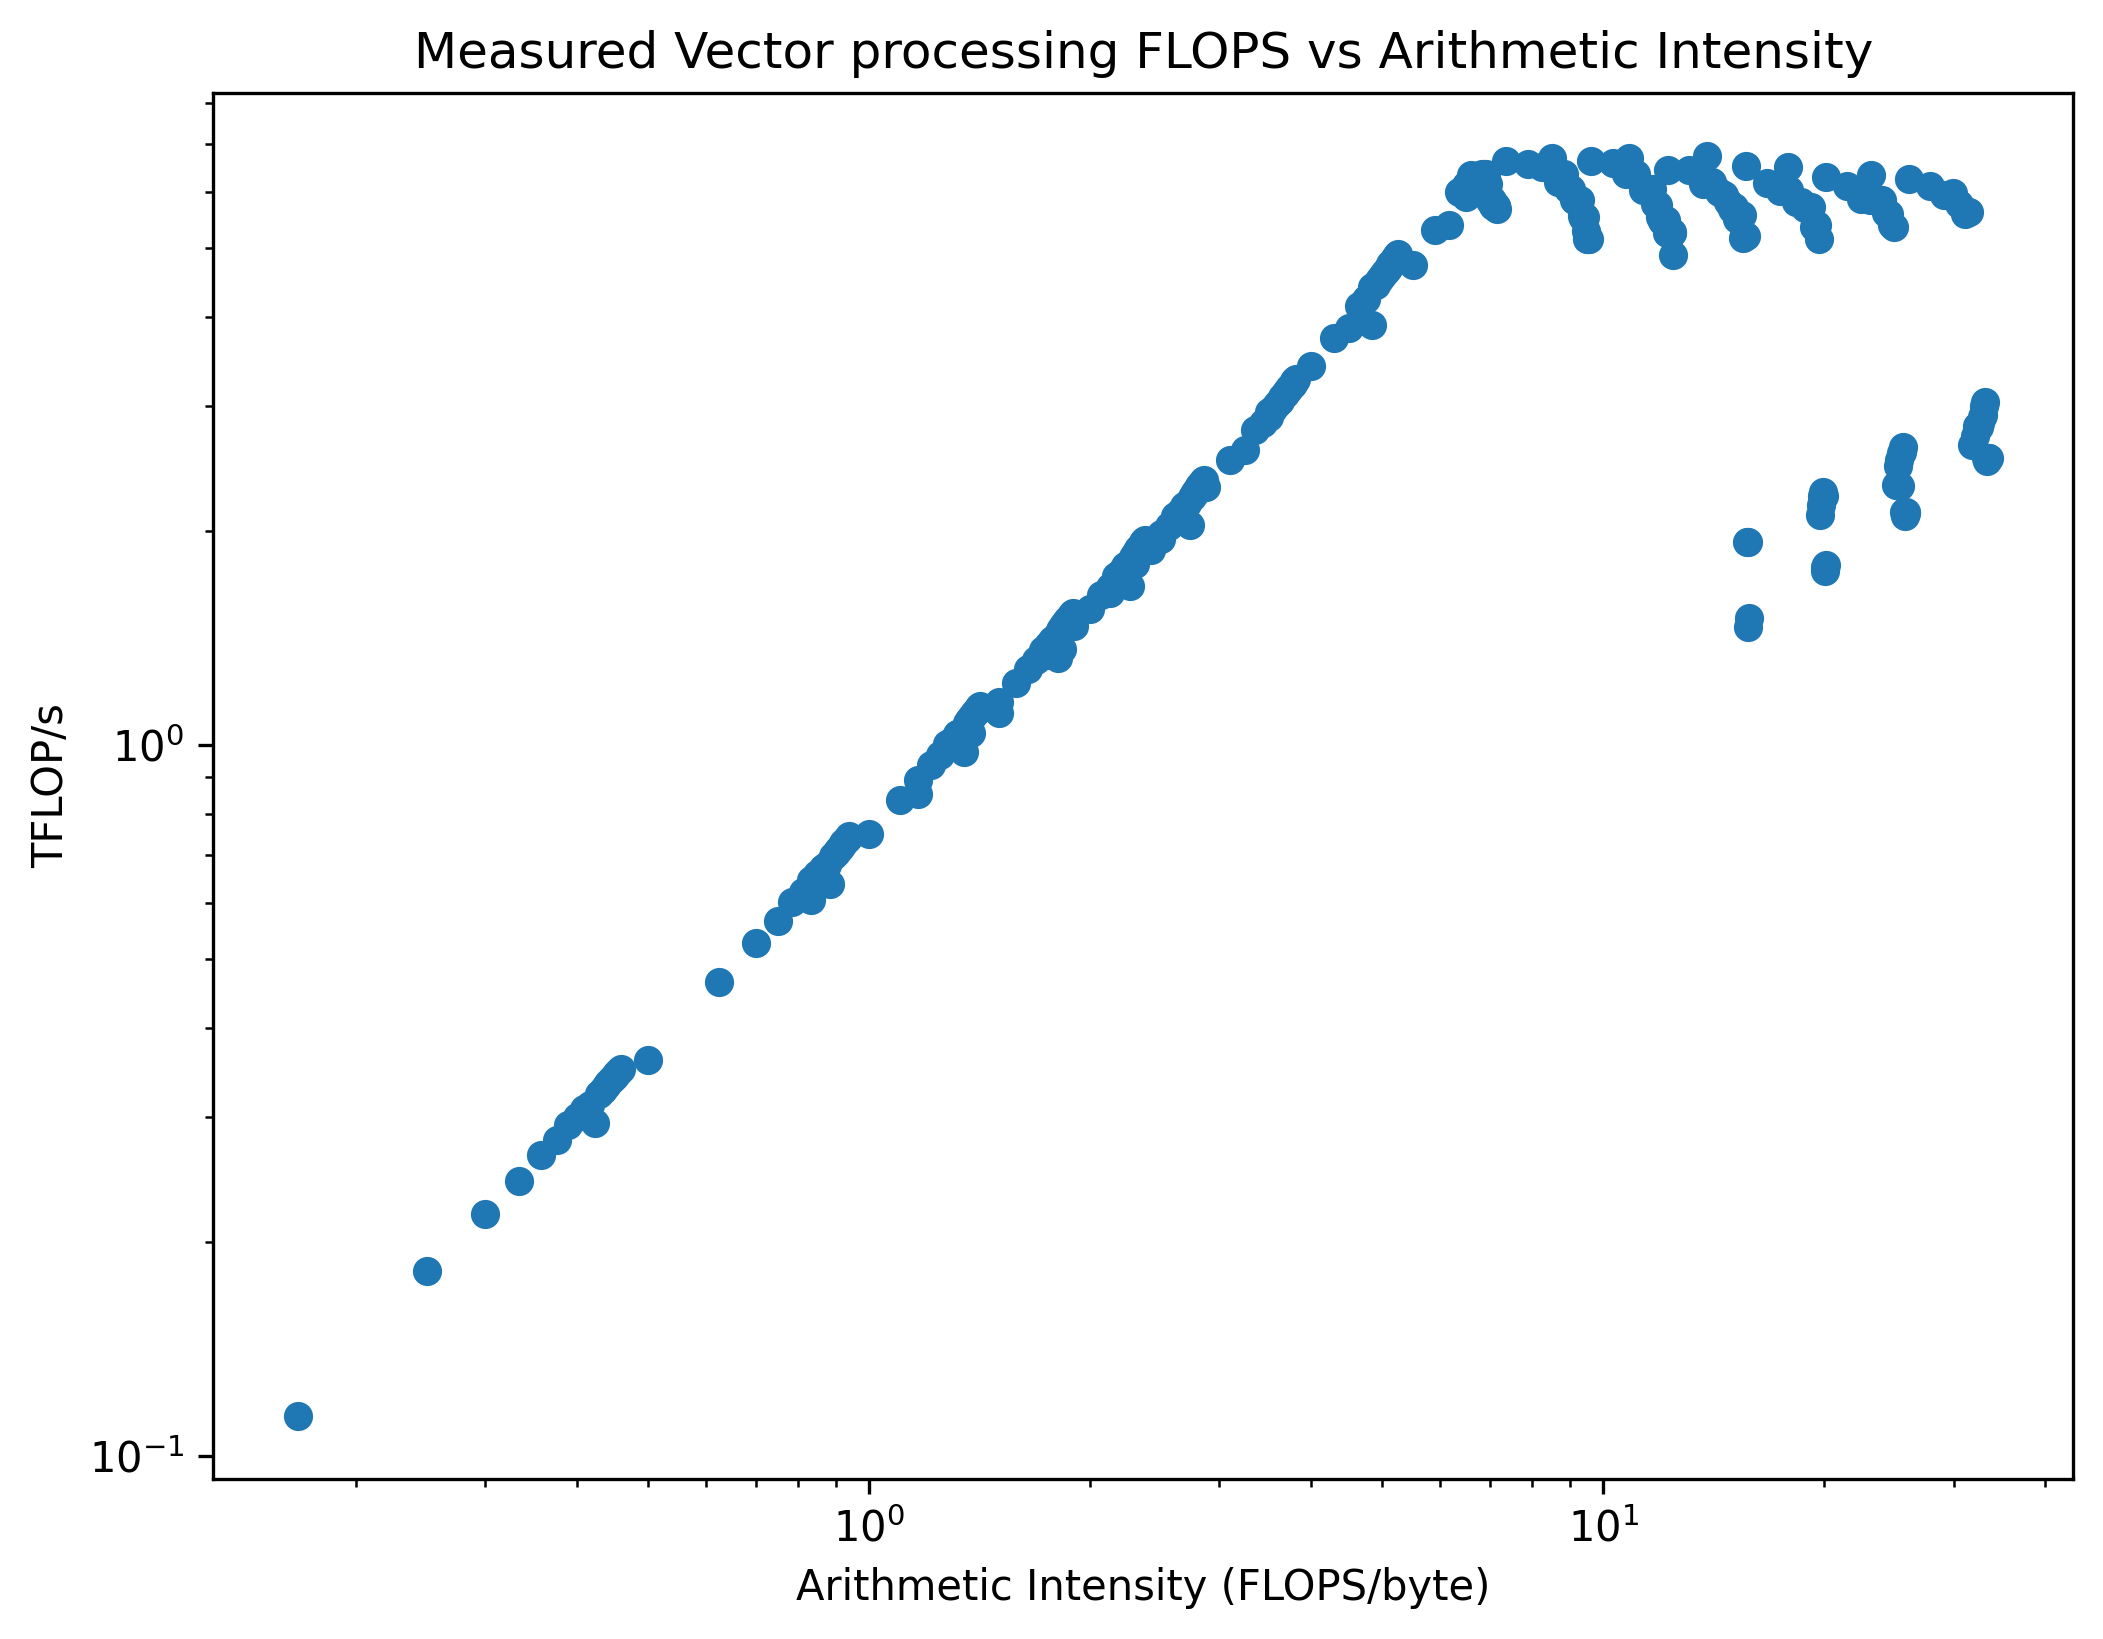

In [4]:
# Plot FLOPS against arithmetic intensity
plt.figure(figsize=(8, 6))
plt.scatter(
  [v.arithmetic_intensity for v in vector_flops.values()],
  [v.tflops for v in vector_flops.values()],
  label='Measured FLOPS',
)
plt.xlabel('Arithmetic Intensity (FLOPS/byte)')
plt.ylabel('TFLOP/s')
plt.xscale('log')
plt.yscale('log')
plt.title('Measured Vector processing FLOPS vs Arithmetic Intensity')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression # Used for initial guess
from scipy.optimize import minimize             # For constrained optimization
from typing import List, Tuple, Optional


# --- Helper functions for scipy.optimize.minimize in log-log space ---
def objective_func_log(params: np.ndarray, log_x: np.ndarray, log_y: np.ndarray) -> float:
    """Objective function in log-log space: Minimize squared error"""
    m_log, c_log = params
    log_y_pred = m_log * log_x + c_log
    return np.sum((log_y - log_y_pred)**2)

def constraint_func_log(params: np.ndarray, log_x: np.ndarray, log_y: np.ndarray) -> np.ndarray:
    """Constraint function in log-log space: m*log(x) + c >= log(y)"""
    m_log, c_log = params
    # Returns m*log(x) + c - log(y) >= 0 for all points
    return m_log * log_x + c_log - log_y
# --- End Helper functions ---


def estimate_roofline(
    arithmetic_intensities: List[float],
    tflops: List[float],
    plot: bool = True,
    max_iterations: int = 10,
    tolerance: float = 1e-3,
) -> Tuple[Optional[float], Optional[float], Optional[float]]:
    """
    Estimates Roofline parameters using iterative refinement with constrained
    optimization performed in log-log space. Ensures the memory line stays
    above the log-transformed envelope points used.

    Args:
        arithmetic_intensities: List of AI values (FLOP/byte).
        tflops: List of corresponding performance values (TFLOP/s).
        plot: If True, generates a plot.
        max_iterations: Maximum number of iterations for refinement.
        tolerance: Convergence tolerance for the ridge point AI.

    Returns:
        A tuple containing:
        - peak_tflops (float): Estimated peak performance (TFLOP/s).
        - log_log_slope (float): Estimated slope 'm' of the memory-bound fit in log-log space.
        - ridge_point_ai (float): Estimated AI at the ridge point (FLOP/byte).
        Returns (None, None, None) if input is invalid or estimation fails.
    """
    if (
        not arithmetic_intensities
        or not tflops
        or len(arithmetic_intensities) != len(tflops)
    ):
        print("Error: Input lists are invalid or have different lengths.")
        return None, None, None

    # --- Initial Data Preparation ---
    ai = np.array(arithmetic_intensities)
    tf = np.array(tflops)
    valid_mask = (ai > 0) & (tf > 0) # Ensure positive values for log
    if not np.any(valid_mask):
        print("Error: No valid data points (AI > 0 and TFLOP/s > 0) found for log transform.")
        return None, None, None
    ai = ai[valid_mask]
    tf = tf[valid_mask]

    sort_indices = np.argsort(ai)
    ai_sorted = ai[sort_indices]
    tf_sorted = tf[sort_indices]

    # --- Compute the upper envelope (Pareto frontier) ---
    envelope_ai = []
    envelope_tf = []
    max_tf_so_far = 0.0
    unique_ai_in_envelope = set()

    for i in range(len(ai_sorted)):
        if tf_sorted[i] > max_tf_so_far:
             max_tf_so_far = tf_sorted[i]
        current_ai = ai_sorted[i]
        # Ensure envelope points are also positive for log transform later
        if current_ai not in unique_ai_in_envelope and max_tf_so_far > 0:
            envelope_ai.append(current_ai)
            envelope_tf.append(max_tf_so_far)
            unique_ai_in_envelope.add(current_ai)
        # Update TF for existing AI if higher, ensuring positive
        elif current_ai in unique_ai_in_envelope and max_tf_so_far > envelope_tf[-1] and max_tf_so_far > 0:
             envelope_tf[-1] = max_tf_so_far


    if not envelope_ai:
         print("Error: Could not determine positive performance envelope.")
         return None, None, None

    envelope_ai = np.array(envelope_ai)
    envelope_tf = np.array(envelope_tf)

    # --- Estimate Compute Bound (Peak Performance) ---
    peak_tflops = np.max(envelope_tf)
    if peak_tflops <= 0: # Should be redundant due to checks above, but safe
        print("Error: Estimated peak TFLOP/s is not positive.")
        return None, None, None
    log_peak_tflops = np.log(peak_tflops) # Pre-calculate log of peak

    # --- Iterative Refinement for Memory Bound and Ridge Point ---
    peak_indices = np.where(np.isclose(envelope_tf, peak_tflops))[0]
    if len(peak_indices) == 0:
        ai_at_peak = envelope_ai[np.argmax(envelope_tf)]
    else:
        ai_at_peak = envelope_ai[peak_indices[0]]

    ridge_point_ai_current = ai_at_peak
    log_log_slope = None # Slope 'm' in log(y) = m*log(x) + c
    log_log_intercept = None # Intercept 'c' in log(y) = m*log(x) + c
    final_ridge_point_ai = None
    fit_successful_this_iteration = False # Flag

    print(f"Starting iterative refinement (log-log fit). Initial Ridge AI guess: {ridge_point_ai_current:.2f}")

    for iteration in range(max_iterations):
        old_ridge_ai = ridge_point_ai_current
        fit_successful_this_iteration = False # Reset flag

        # Select envelope points strictly *before* the current ridge point estimate
        mem_bound_mask = envelope_ai < old_ridge_ai
        mem_bound_ai = envelope_ai[mem_bound_mask]
        mem_bound_tf = envelope_tf[mem_bound_mask]

        # Ensure selected points are valid for log transform
        valid_log_mask = (mem_bound_ai > 0) & (mem_bound_tf > 0)
        mem_bound_ai = mem_bound_ai[valid_log_mask]
        mem_bound_tf = mem_bound_tf[valid_log_mask]

        if len(mem_bound_ai) < 2:
            print(f"Warning: Not enough valid positive envelope points ({len(mem_bound_ai)}) below AI={old_ridge_ai:.2f} for log-log fit. Stopping iteration.")
            if log_log_slope is not None: # Check if previous iteration was successful
                final_ridge_point_ai = old_ridge_ai
            else:
                final_ridge_point_ai = None
            break

        # Transform selected data to log space
        log_mem_bound_ai = np.log(mem_bound_ai)
        log_mem_bound_tf = np.log(mem_bound_tf)

        # --- Constrained Optimization in log-log space ---
        # 1. Get initial guess using unconstrained fit on log data
        try:
            X_init = log_mem_bound_ai.reshape(-1, 1)
            y_init = log_mem_bound_tf
            model_init = LinearRegression()
            model_init.fit(X_init, y_init)
            m_init_log = model_init.coef_[0]
            c_init_log = model_init.intercept_
            # No need to check for non-positive slope here, can be valid in log-log
            x0 = [m_init_log, c_init_log] # Initial guess [m_log, c_log]
        except Exception as e:
             print(f"Warning: Initial unconstrained log-log linear regression failed: {e}. Stopping iteration.")
             if log_log_slope is not None:
                 final_ridge_point_ai = old_ridge_ai
             else:
                 final_ridge_point_ai = None
             break

        # 2. Define constraints dictionary for log-log space
        constraints = ({'type': 'ineq', 'fun': constraint_func_log, 'args': (log_mem_bound_ai, log_mem_bound_tf)})

        # 3. Run the optimization
        try:
            # Using objective and constraint functions defined for log-space
            result = minimize(objective_func_log, x0, args=(log_mem_bound_ai, log_mem_bound_tf),
                              method='SLSQP', constraints=constraints)

            if not result.success:
                print(f"Warning: Constrained optimization (log-log) failed to converge in iteration {iteration + 1}: {result.message}")
                if log_log_slope is not None:
                    final_ridge_point_ai = old_ridge_ai
                else:
                    final_ridge_point_ai = None
                break

            # Optimization succeeded
            current_m_log, current_c_log = result.x

        except Exception as e:
            print(f"Warning: Constrained optimization (log-log) raised an exception during iteration {iteration + 1}: {e}. Stopping.")
            if log_log_slope is not None:
                 final_ridge_point_ai = old_ridge_ai
            else:
                 final_ridge_point_ai = None
            break
        # --- End Constrained Optimization ---

        # Check if the optimized slope 'm_log' is valid (positive - needed for ridge calc)
        # While log-log slope can be anything, ridge calculation needs m_log != 0
        # and typically expect positive slope in memory bound region.
        if current_m_log <= 0:
            print(f"Warning: Optimization resulted in non-positive log-log slope ({current_m_log:.2f}). Cannot calculate ridge point reliably. Stopping iteration.")
            if log_log_slope is not None:
                 final_ridge_point_ai = old_ridge_ai
            else:
                 final_ridge_point_ai = None
            break

        # If we got here, the optimization was successful and slope is positive
        fit_successful_this_iteration = True
        log_log_slope = current_m_log     # Store the log-log slope 'm_log'
        log_log_intercept = current_c_log # Store the log-log intercept 'c_log'

        # Calculate the intersection AI with the peak performance line in log-log space
        # log(peak) = m_log * log(ridge_ai) + c_log
        # log(ridge_ai) = (log(peak) - c_log) / m_log
        try:
             log_ridge_ai_candidate = (log_peak_tflops - log_log_intercept) / log_log_slope
             ridge_point_ai_candidate = np.exp(log_ridge_ai_candidate)
        except (ZeroDivisionError, ValueError, OverflowError) as e: # Catch potential math errors
             print(f"Warning: Error calculating ridge point AI from log-log fit: {e}. Stopping iteration.")
             final_ridge_point_ai = old_ridge_ai # Use previous valid value
             break

        # Basic sanity check on the candidate AI
        if not np.isfinite(ridge_point_ai_candidate) or ridge_point_ai_candidate <= 0:
             print(f"Warning: Calculated ridge point AI ({ridge_point_ai_candidate}) is invalid. Stopping iteration.")
             final_ridge_point_ai = old_ridge_ai # Use previous valid value
             break

        # Update current estimates for the next iteration or final result
        ridge_point_ai_current = ridge_point_ai_candidate

        print(f"  Iter {iteration + 1}: Opt Success={result.success}, log-log Slope={log_log_slope:.2f}, log-log Intercept={log_log_intercept:.2f}, New Ridge AI={ridge_point_ai_current:.2f}")

        # Check for convergence
        if abs(ridge_point_ai_current - old_ridge_ai) < tolerance:
            print(f"Convergence reached after {iteration + 1} iterations.")
            final_ridge_point_ai = ridge_point_ai_current
            break
        # Check if max iterations reached
        if iteration == max_iterations - 1:
             print(f"Warning: Maximum iterations ({max_iterations}) reached without convergence.")
             final_ridge_point_ai = ridge_point_ai_current # Use the last calculated value

    # If loop finished without ever having a successful fit
    if not fit_successful_this_iteration and log_log_slope is None:
         print("Error: Could not establish a valid memory-bound fit via log-log constrained optimization.")
         final_ridge_point_ai = None # Ensure failure state

    # --- Plotting (Optional) ---
    if plot:
        plt.figure(figsize=(10, 7))
        plt.scatter(ai, tf, alpha=0.3, label="Benchmark Data", color="gray", s=30)
        plt.plot(envelope_ai, envelope_tf, "-", label="Performance Envelope", color="red", linewidth=1.5)

        if log_log_slope is not None and final_ridge_point_ai is not None and log_log_intercept is not None:
            # Plot fitted memory-bound line from log-log fit: tf = exp(c_log) * ai^m_log
            plot_start_ai = np.min(envelope_ai) * 0.8
            # Ensure start AI is positive
            plot_start_ai = max(plot_start_ai, 1e-9) # Avoid AI=0

            ai_mem_plot = np.geomspace(plot_start_ai, final_ridge_point_ai, 100) # Use geomspace for log plot
            # Calculate corresponding tf values using the log-log fit equation
            tf_mem_plot = np.exp(log_log_intercept) * (ai_mem_plot ** log_log_slope)

            # Ensure line stays positive and below peak
            valid_plot_mask = (tf_mem_plot <= peak_tflops * 1.001) & (tf_mem_plot > 0) & (ai_mem_plot <= final_ridge_point_ai)
            ai_mem_plot = ai_mem_plot[valid_plot_mask]
            tf_mem_plot = tf_mem_plot[valid_plot_mask]

            if len(ai_mem_plot) > 0:
                 # Label reflects log-log slope, not linear bandwidth directly
                 plt.plot(ai_mem_plot, tf_mem_plot, "--", label=f"Memory Bound (log-log slope={log_log_slope:.2f})", color="blue", linewidth=2)

            # Plot fitted compute-bound line
            ai_compute_plot = np.array([final_ridge_point_ai, np.max(envelope_ai) * 1.2])
            tf_compute_plot = np.array([peak_tflops, peak_tflops])
            plt.plot(ai_compute_plot, tf_compute_plot, "--", label=f"Compute Bound (Peak={peak_tflops:.2f} TFLOP/s)", color="green", linewidth=2)

            # Mark the ridge point
            plt.plot(final_ridge_point_ai, peak_tflops, "X", color="purple", markersize=10, label=f"Ridge Point (AI={final_ridge_point_ai:.2f})")

        elif peak_tflops is not None:
            ai_compute_plot = np.array([np.min(envelope_ai) * 0.8, np.max(envelope_ai) * 1.2])
            tf_compute_plot = np.array([peak_tflops, peak_tflops])
            plt.plot(ai_compute_plot, tf_compute_plot, "--", label=f"Compute Bound (Peak={peak_tflops:.2f} TFLOP/s)", color="green", linewidth=2)

        plt.xscale("log")
        plt.yscale("log")
        # Dynamic limits need care with log scales, ensure positive min
        x_min_data = np.min(ai)
        x_min = x_min_data * 0.8 if x_min_data > 0 else 1e-2 # Fallback if min data is 0 or neg
        x_max = np.max(ai) * 1.2

        y_min_data = np.min(tf)
        y_min = y_min_data * 0.8 if y_min_data > 0 else 1e-1 # Fallback
        y_max_data = np.max(tf)
        y_max = max(y_max_data, peak_tflops if peak_tflops else 0) * 1.2
        # Adjust y_min based on fitted line if needed
        if log_log_slope is not None and log_log_intercept is not None:
             y_at_min_ai = np.exp(log_log_intercept) * (x_min ** log_log_slope)
             if np.isfinite(y_at_min_ai) and y_at_min_ai > 0:
                 y_min = min(y_min, y_at_min_ai * 0.8)

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel("Arithmetic Intensity (FLOP/byte)")
        plt.ylabel("Performance (TFLOP/s)")
        plt.title("Roofline Model Estimation (Log-Log Constrained Fit)") # Updated title
        plt.legend()
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.show()
    
    # Estimate memory bandwidth
    memory_bw = np.exp(log_log_intercept) if log_log_intercept is not None else None

    # Return peak, memory bw, and ridge point AI
    return peak_tflops, memory_bw, final_ridge_point_ai

Starting iterative refinement (log-log fit). Initial Ridge AI guess: 13.83
  Iter 1: Opt Success=True, log-log Slope=1.08, log-log Intercept=-0.20, New Ridge AI=7.01
  Iter 2: Opt Success=True, log-log Slope=1.08, log-log Intercept=-0.20, New Ridge AI=7.01
Convergence reached after 2 iterations.


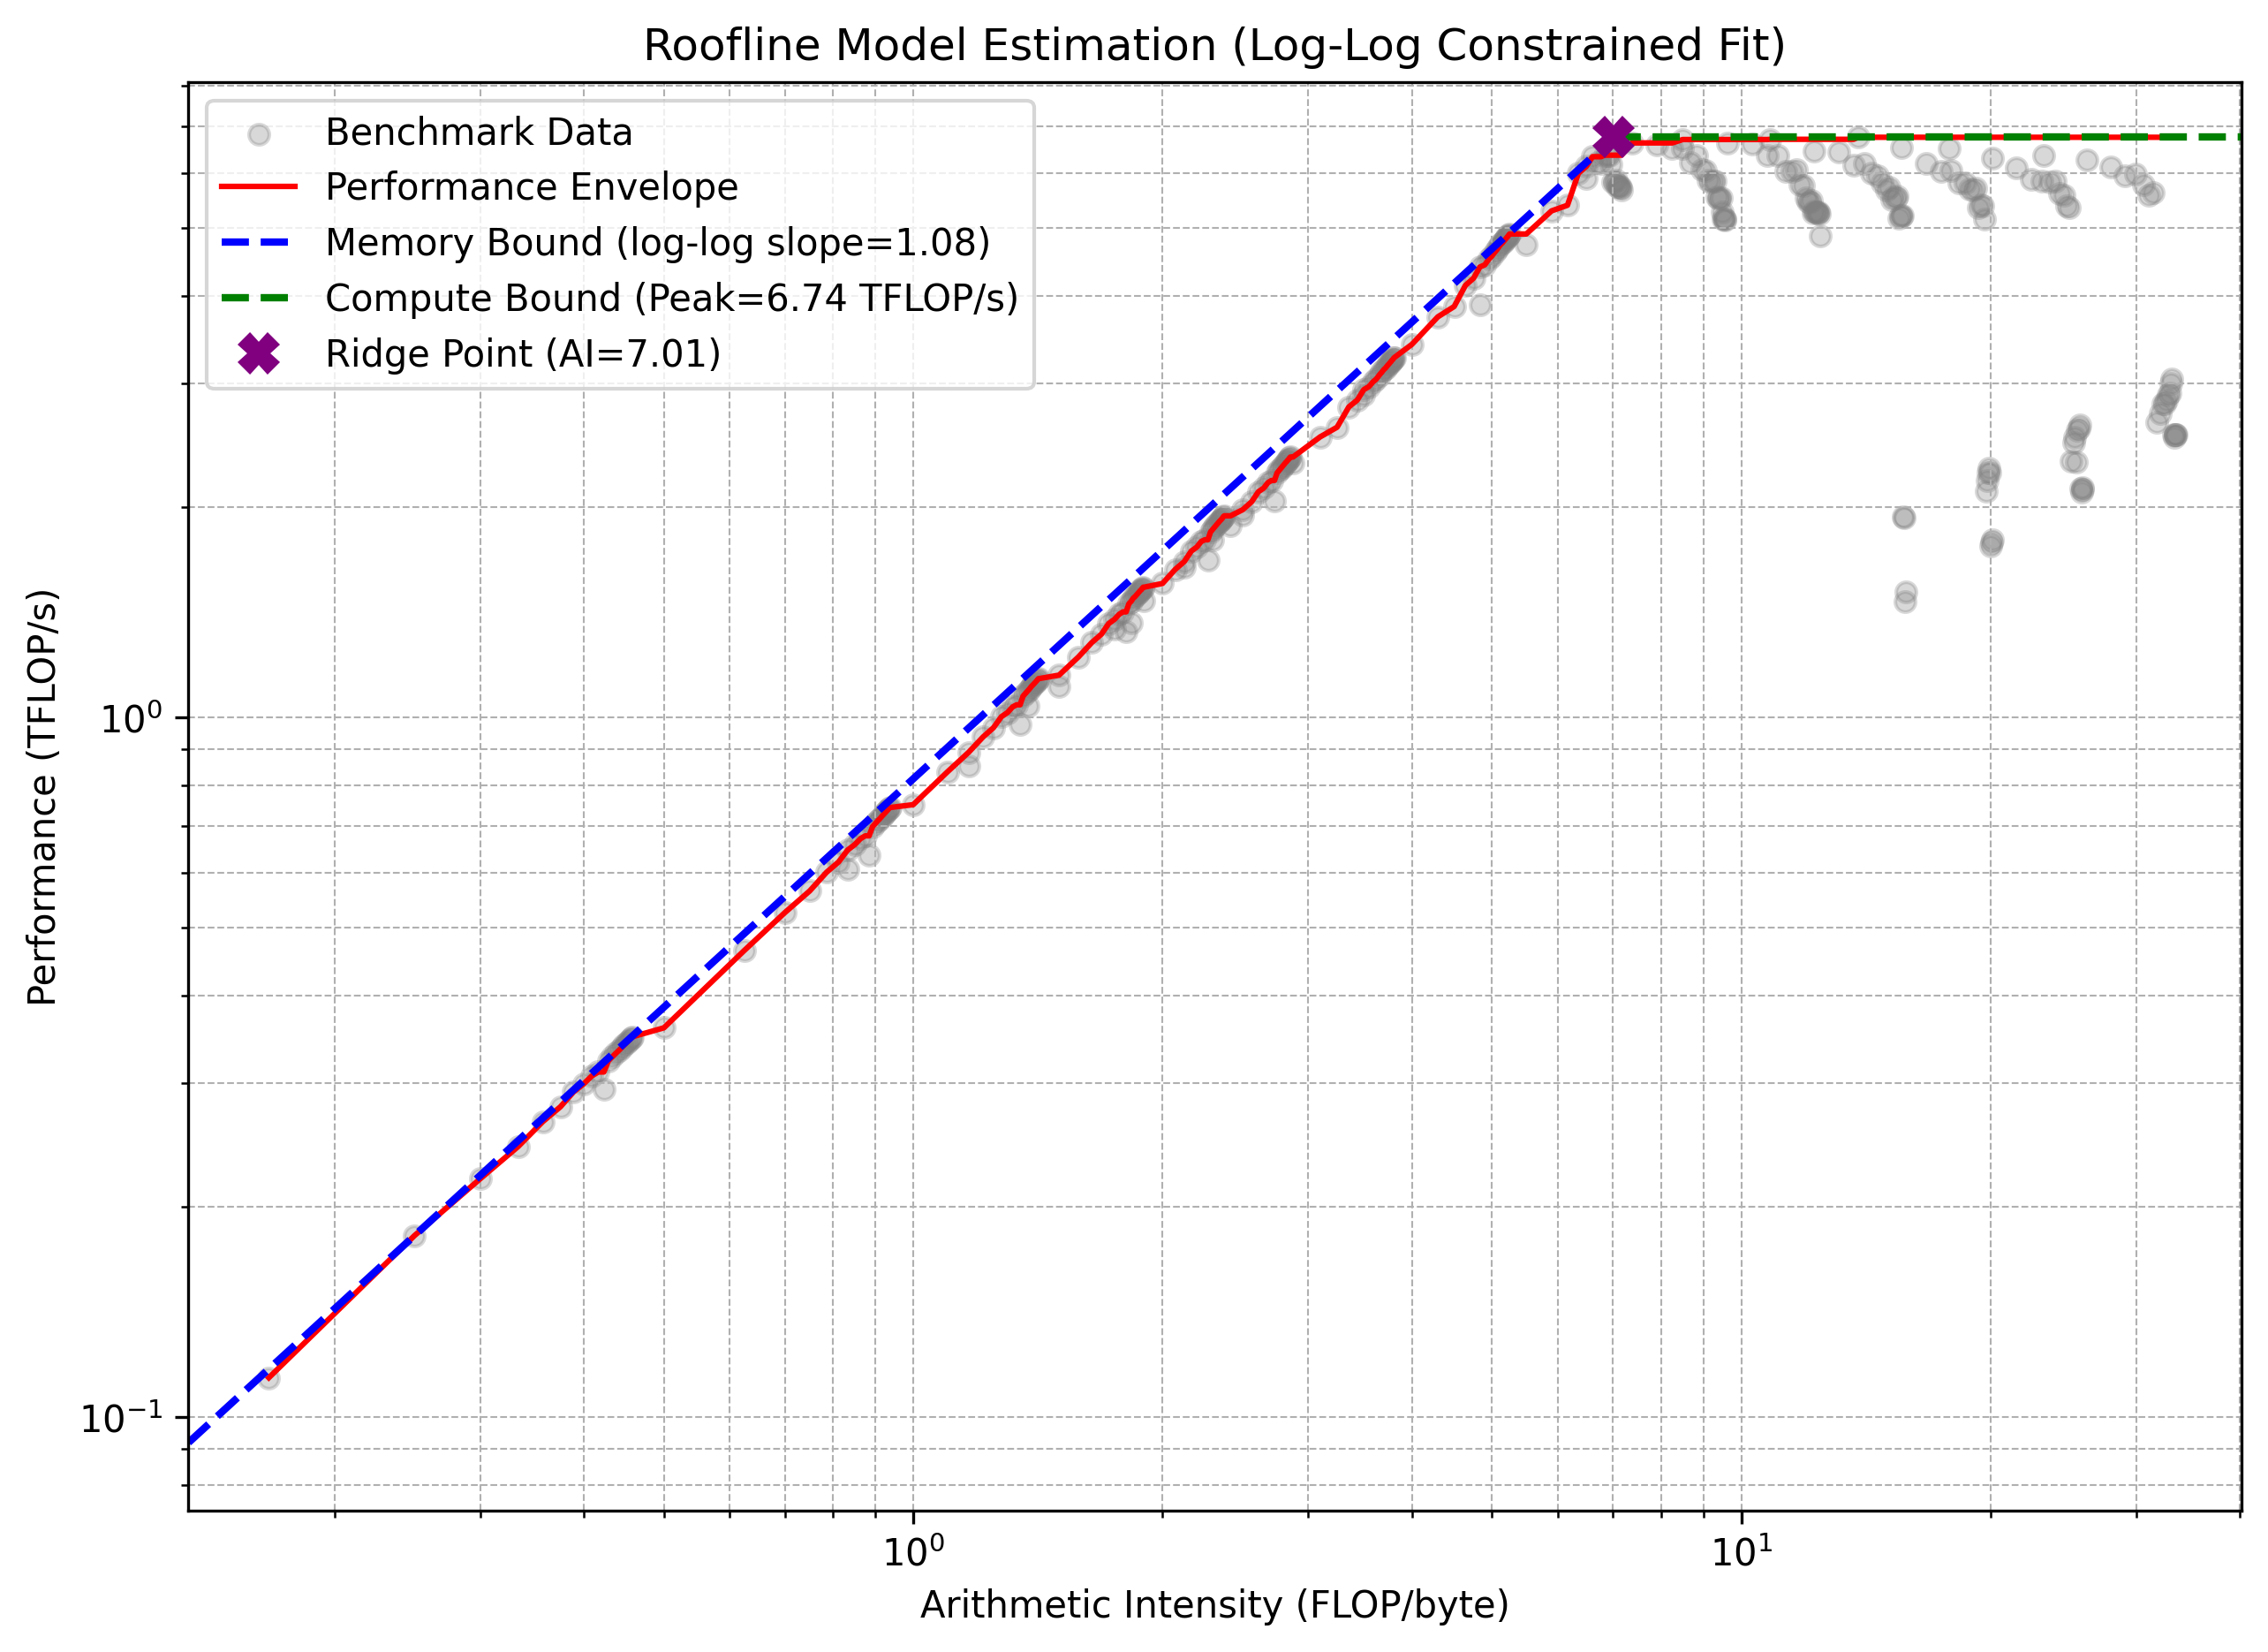


Peak TFLOP/s: 6.74 TFLOP/s
Memory Bandwidth: 0.82 TB/s
Ridge Point AI: 7.01 FLOP/byte



In [6]:
peak_tflops, memory_bw, ridge_point_ai = estimate_roofline(
  [v.arithmetic_intensity for v in vector_flops.values()],
  [v.tflops for v in vector_flops.values()],
)
print(f"""
Peak TFLOP/s: {peak_tflops:.2f} TFLOP/s
Memory Bandwidth: {memory_bw:.2f} TB/s
Ridge Point AI: {ridge_point_ai:.2f} FLOP/byte
""")

In [7]:
print(f"Published HBM bandwidth: {tpu_spec.hbm_bandwidth / 1e12:.2f} TB/s")

Published HBM bandwidth: 0.82 TB/s


We estimate that the HBM bandwidth is 0.82 TB/s from experiments, which is close!
We also see that the performance of the VPU (the vector processing unit of the
TPU) is ~6.74 TFLOP/s, much slower than the MXU (197 TFLOP/s).

# Matrix roofline

In [8]:
def measure_matmul_flops(matrix_size: int, middle_size: int):
  NUM_ITERS = 100
  num_matrices = int(1 * 1024 * 1024 * 1024 // (matrix_size * middle_size))
  if matrix_size == 64:
    num_matrices = int(num_matrices / 2)
  if num_matrices > 128:
    num_matrices = int(int(num_matrices / 128) * 128)
  a = torch.randn(num_matrices, matrix_size, middle_size, dtype=torch.bfloat16, requires_grad=False, device=xm.xla_device())
  b = torch.randn(num_matrices, middle_size, matrix_size, dtype=torch.bfloat16, requires_grad=False, device=xm.xla_device())
  torch_xla.sync()
  
  # Measure in a loop
  times = []
  for i in range(NUM_ITERS):
    torch_xla.sync(wait=True)
    result = torch.einsum('bxy,byz->bxz', a, b)
    start = time.time()
    torch_xla.sync()
    result = xm.unlazy([result])
    end = time.time()
    times.append(end - start)
  
  run_time = float(np.median(times))
  flops = 2 * matrix_size * middle_size * matrix_size * num_matrices
  bytes_transferred = (2 * matrix_size * middle_size * num_matrices * 2) + (matrix_size * matrix_size * num_matrices * 2)  # 2 bytes per BF16
  
  return BenchmarkResult(
    flops=flops / run_time,
    arithmetic_intensity=flops / bytes_transferred,
  )

In [9]:
import gc
gc.collect()
matmul_flops = {}
for matrix_size in [128, 256, 384, 512, 640, 768, 896, 1024, 1152, 1280, 2048, 4096, 8192, 16384, 32768]:
  middle_sizes = [matrix_size]
  if matrix_size < 16384:
    middle_sizes.append(matrix_size * 2)
  for middle_size in middle_sizes:
    matmul_flops[(matrix_size, middle_size)] = measure_matmul_flops(matrix_size, middle_size)
    print(f"matmul_flops[{matrix_size}, {middle_size}] = {matmul_flops[(matrix_size, middle_size)]}")
    gc.collect()

matmul_flops[128, 128] = 28.9584 TFLOP/s, 42.6667 FLOPS/byte
matmul_flops[128, 256] = 36.8328 TFLOP/s, 51.2000 FLOPS/byte
matmul_flops[256, 256] = 57.7312 TFLOP/s, 85.3333 FLOPS/byte
matmul_flops[256, 512] = 73.8390 TFLOP/s, 102.4000 FLOPS/byte
matmul_flops[384, 384] = 87.0161 TFLOP/s, 128.0000 FLOPS/byte
matmul_flops[384, 768] = 110.1210 TFLOP/s, 153.6000 FLOPS/byte
matmul_flops[512, 512] = 95.7516 TFLOP/s, 170.6667 FLOPS/byte
matmul_flops[512, 1024] = 133.7166 TFLOP/s, 204.8000 FLOPS/byte
matmul_flops[640, 640] = 119.3259 TFLOP/s, 213.3333 FLOPS/byte
matmul_flops[640, 1280] = 177.0533 TFLOP/s, 256.0000 FLOPS/byte
matmul_flops[768, 768] = 161.6293 TFLOP/s, 256.0000 FLOPS/byte
matmul_flops[768, 1536] = 172.2427 TFLOP/s, 307.2000 FLOPS/byte
matmul_flops[896, 896] = 149.0553 TFLOP/s, 298.6667 FLOPS/byte
matmul_flops[896, 1792] = 166.0576 TFLOP/s, 358.4000 FLOPS/byte
matmul_flops[1024, 1024] = 165.7449 TFLOP/s, 341.3333 FLOPS/byte
matmul_flops[1024, 2048] = 178.1193 TFLOP/s, 409.6000 FLOP

Starting iterative refinement (log-log fit). Initial Ridge AI guess: 10922.67
  Iter 1: Opt Success=True, log-log Slope=0.24, log-log Intercept=3.87, New Ridge AI=351.65
  Iter 2: Opt Success=True, log-log Slope=0.93, log-log Intercept=0.02, New Ridge AI=277.46
  Iter 3: Opt Success=True, log-log Slope=0.99, log-log Intercept=-0.26, New Ridge AI=268.27
  Iter 4: Opt Success=True, log-log Slope=0.99, log-log Intercept=-0.26, New Ridge AI=268.27
Convergence reached after 4 iterations.


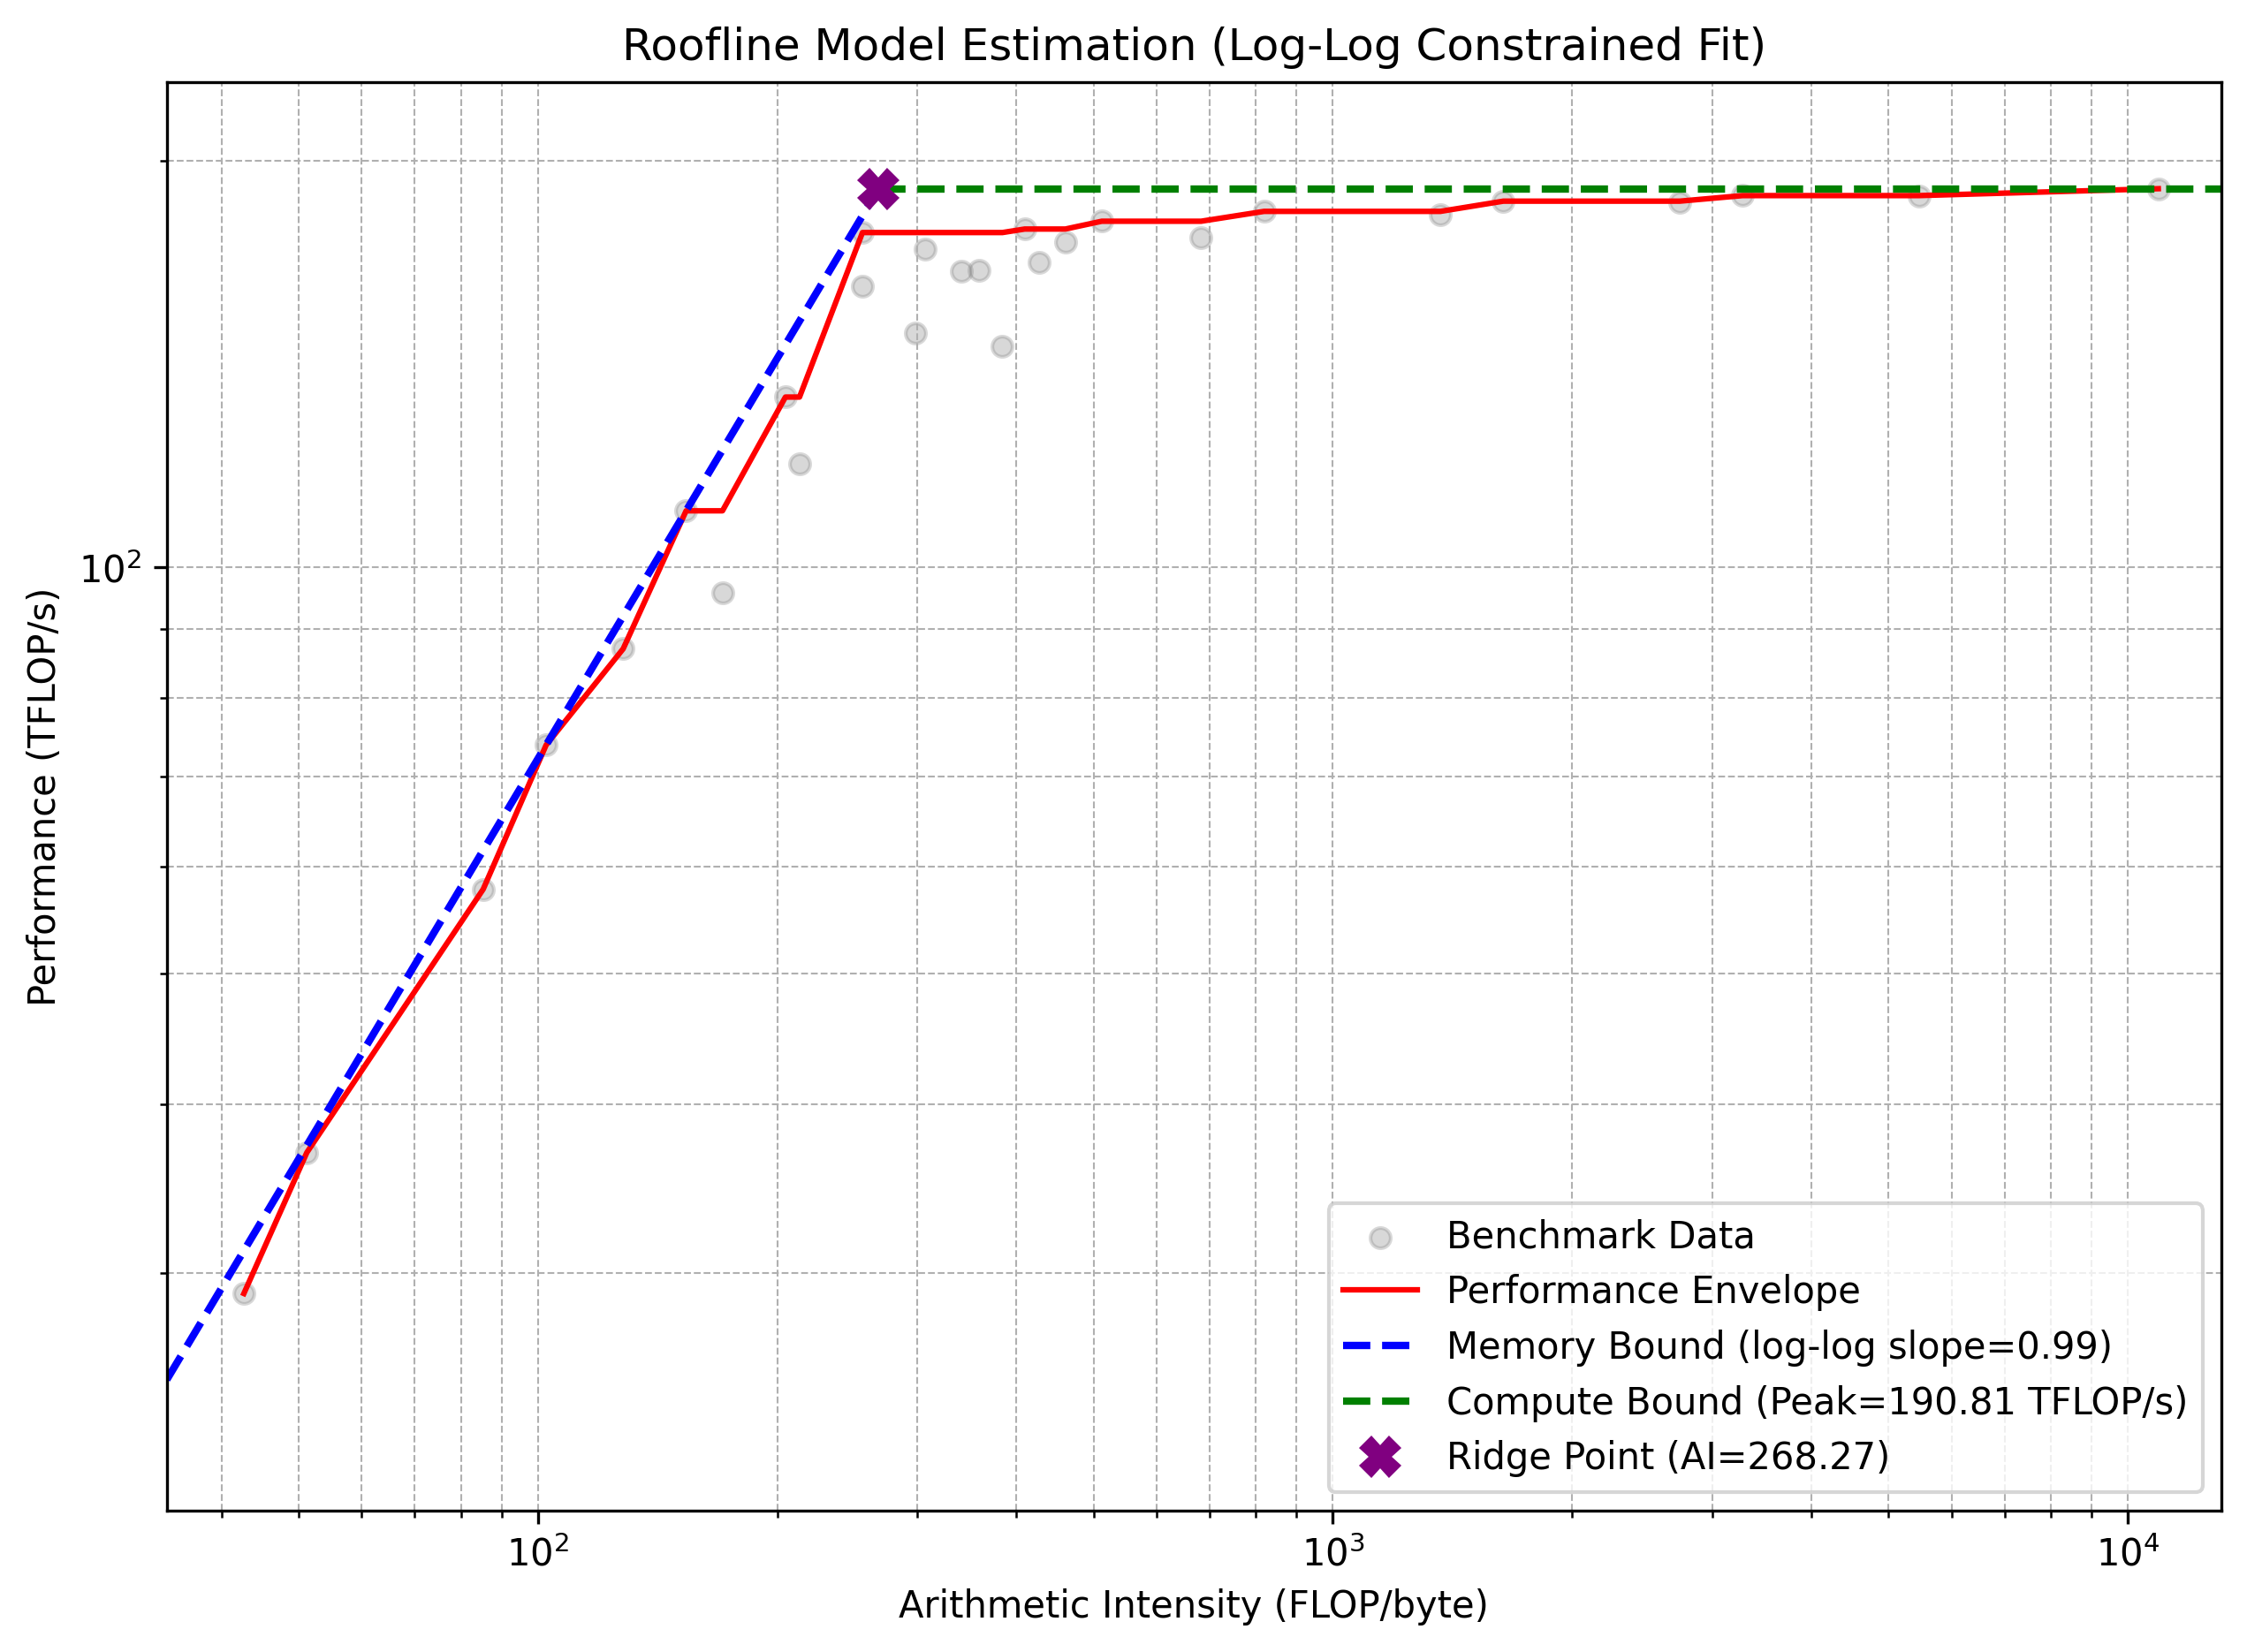


Peak TFLOP/s: 190.81 TFLOP/s
Memory Bandwidth: 0.77 TB/s
Ridge Point AI: 268.27 FLOP/byte

Published MXU FLOPS: 197.00 TFLOP/s
Published HBM bandwidth: 0.82 TB/s
Published AI: 240.54 FLOP/byte



In [10]:
peak_tflops, memory_bw, ridge_point_ai = estimate_roofline(
  [v.arithmetic_intensity for v in matmul_flops.values()],
  [v.tflops for v in matmul_flops.values()],
)
print(f"""
Peak TFLOP/s: {peak_tflops:.2f} TFLOP/s
Memory Bandwidth: {memory_bw:.2f} TB/s
Ridge Point AI: {ridge_point_ai:.2f} FLOP/byte

Published MXU FLOPS: {tpu_spec.mxu_flops / 1e12:.2f} TFLOP/s
Published HBM bandwidth: {tpu_spec.hbm_bandwidth / 1e12:.2f} TB/s
Published AI: {tpu_spec.arithmetic_intensity():.2f} FLOP/byte
""")

Again we're pretty close to the published spec. Roofline estimation works!